## Добиться вразумительного результата от модели, собранной на занятии (3 угаданные картинки из 4 предложенных на семинаре). Варианты изменений:
изменение слоёв и их количества; <br>
изменение метода оптимизации;  <br>
изменение процесса обучения;  <br>
для продвинутых: преобразование данных.

Для получения результата 30+ правильных ответов на 40 первых примеров из теста оказалось достаточно поменять архитектуру сети (сделать 3 свёрточных слоя, вместо 2х) и поменять оптимизацию на Адам.

In [1]:
from torch import nn 
from torch import optim
from torch.autograd import Variable
import numpy as np

import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import torchvision

In [2]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
train_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                             train=True,  
                                             transform=transforms.ToTensor(), 
                                             download=True)


image, label = train_dataset[0]
print (image.size())
print (classes[label])

Files already downloaded and verified
torch.Size([3, 32, 32])
frog


In [4]:
img = image.permute(1, 2, 0).numpy()

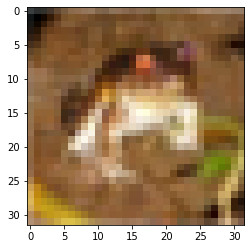

In [5]:
plt.imshow(img)

In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                         shuffle=False)

Files already downloaded and verified


In [7]:
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__() 
        # 3, 32, 32    
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
        self.max_pool = nn.MaxPool2d(2, 2)
        # 32, 16, 16
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        # self.max_pool = nn.MaxPool2d(2, 2)
        # 64, 8, 8
        self.conv3 = nn.Conv2d(64, 64, 5, padding=2)
        # self.max_pool = nn.MaxPool2d(2, 2)
        # 64, 4, 4
        self.fc1 = nn.Linear(64 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        x = F.relu(self.conv3(x))
        x = self.max_pool(x)
        
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net().to('cpu')

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [9]:
def train(net, train_loader, optimizer, criterion, n_epochs=10):
    for epoch in range(n_epochs): 
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0], data[1]

            # обнуляем градиент
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # выводим статистику о процессе обучения
            running_loss += loss.item()
            if i % 300 == 0:   
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Training is finished!')

In [10]:
def save_model(net, path='./cifar_net_version_test_intro.pth'):
    torch.save(net.state_dict(), path)

In [11]:
def print_model(net):
    print("Model state_dict: ")
    for param in net.state_dict():
        print(param," \ ", net.state_dict()[param].size())

In [12]:
def load_net(path='./cifar_net_version_test_intro.pth'):
    net = Net()
    net.load_state_dict(torch.load(PATH))
    return net

In [13]:
print_model(net)

Model state_dict: 
conv1.weight  \  torch.Size([32, 3, 5, 5])
conv1.bias  \  torch.Size([32])
conv2.weight  \  torch.Size([64, 32, 5, 5])
conv2.bias  \  torch.Size([64])
conv3.weight  \  torch.Size([64, 64, 5, 5])
conv3.bias  \  torch.Size([64])
fc1.weight  \  torch.Size([256, 1024])
fc1.bias  \  torch.Size([256])
fc2.weight  \  torch.Size([10, 256])
fc2.bias  \  torch.Size([10])


In [14]:
train(net, train_loader, optimizer, criterion)

[1,     1] loss: 0.001
[1,   301] loss: 0.267
[1,   601] loss: 0.211
[2,     1] loss: 0.001
[2,   301] loss: 0.177
[2,   601] loss: 0.164
[3,     1] loss: 0.001
[3,   301] loss: 0.143
[3,   601] loss: 0.138
[4,     1] loss: 0.000
[4,   301] loss: 0.122
[4,   601] loss: 0.118
[5,     1] loss: 0.000
[5,   301] loss: 0.105
[5,   601] loss: 0.104
[6,     1] loss: 0.000
[6,   301] loss: 0.091
[6,   601] loss: 0.094
[7,     1] loss: 0.000
[7,   301] loss: 0.081
[7,   601] loss: 0.083
[8,     1] loss: 0.000
[8,   301] loss: 0.069
[8,   601] loss: 0.073
[9,     1] loss: 0.000
[9,   301] loss: 0.061
[9,   601] loss: 0.066
[10,     1] loss: 0.000
[10,   301] loss: 0.051
[10,   601] loss: 0.056
Training is finished!


In [18]:
save_model(net)

In [15]:
def test_model(net, test_loader, classes=classes, n_times=1):
    data_iter = iter(test_loader)
    correct_sum = 0
    total_count = 0
    for i in range(n_times):
        images, labels = data_iter.next()
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        correct_sum += np.sum((labels == predicted).numpy())
        total_count += len(labels)
    print(f"Correct prediction: {correct_sum} Total count: {total_count}")

In [16]:
test_model(net, test_loader, n_times=10)

Correct prediction: 34 Total count: 40


## Взять часть, где мы делали один шаг обучения, и обернуть его в цикл по схеме, как обучали модель в конце занятия.

**Initialization**

In [17]:
linear = nn.Linear(2, 2)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(linear.parameters(), lr=0.01)
X = [Variable(torch.randn(2), requires_grad = True)]
y = [Variable(torch.randn(2), requires_grad = False)]

**Train step**

In [21]:
N_EPOCHS = 5
for epoch in range(N_EPOCHS):
    running_loss = 0.0
    
    for i in range(len(X)):
        optimizer.zero_grad()
        pred = linear(X[i])
        loss = criterion(pred, y[i])
        print('loss: ', loss.item())
        loss.backward()
        optimizer.step()
        # выводим статистику о процессе обучения
        running_loss += loss.item()
        if i % 1 == 0:   
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

loss:  4.086215019226074
[1,     1] loss: 0.002
loss:  3.6865689754486084
[2,     1] loss: 0.002
loss:  3.3260090351104736
[3,     1] loss: 0.002
loss:  3.00071382522583
[4,     1] loss: 0.002
loss:  2.707233428955078
[5,     1] loss: 0.001


## Переписать программу на PyTorch

In [ ]:
class Task3Net(nn.Module):
    def __init__(self):
        super().__init__() 
        self.fc1 = nn.Linear(28*28, 128)
        self.dropout = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.softmax(x)
        return x

In [ ]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss = nn.CrossEntropyLoss()